# Capstone Project

In this Capstone Project you will be engaging with the stock price data.  This includes daily price data on several hundred stocks over a period of 5 years.  
The data is from [Kaggle](https://www.kaggle.com/dgawlik/nyse#prices-split-adjusted.csv) and is available in its original form there under a CC0 liscence.  We will be using a slightly preprocessed version in the repo.  

In this Notebook you will be looking at Pairs Trading strategies.  

## Outline: 
1. Getting and describing the data. 

2. Exploring, cleaning and visualizing the data

3. Developing analytics
- Using Correlation
- Using Cointegration (optional)

4. Risk review: improving accuracy and realism
- Time keeps on slipping into the future
- Transaction concerns
- Multiple hypothesis bias

5. Taking the next steps
    
6. Wrapping up

## Options
As we progress you are encouraged to take this dataset further.  You are also encouraged to explore any aspects of the data. Develop your own algorithms.  Be explicit about your inquiry and success in predicting affects on our world.

## Warning: Not financial advice
This exercise is meant purely for educational purposes, uses many simplifications and is not intended, nor should be considered as financial advice. There are many risks involved in implementation of financial trading strategies that are not considered nor described here. 

### Setting up
If you have not yet set up your environment, you can easily do so with VS Code, and the python extension and Anaconda.  

For VSCode go here: [https://code.visualstudio.com/]

and then you can follow these instructions:
[https://code.visualstudio.com/docs/python/data-science-tutorial]

## 0. Overview
Pairs trading is a type of statistical arbitrage, which is exploiting statistical properties that we believe can make money if they continue.   
General Idea:  
1) Find two stocks which move similarly.  
2) Find where the prices move apart.  
3) Sell the high one and buy the low one.  
4) Wait for them to come back into line.  

Goals:

1. Practice obtaining maniputaling and thinking about time series data.

2. Gain awareness of the challenges in working with financial data.

## 1. Getting and Describing the data.

Now you are going to get a chance to build a pairs trading model that could help you predict when to buy and sell stocks.  To get started, you must load the data.

First we need to import our tools into [Python](Data_Science_2/Full_Day/1-Cleaning_and_Manipulating-Reference.ipynb). Numpy is a mathematical toolkit that helps us quickly manipulate numerical data. Pandas is a data scientist's "swiss army knife", with a series and a dataframe object that help manipulate and clean data. Matplotlib and Seaborn work together to produce vizualisations. Scipy and [Statsmodels](https://www.statsmodels.org/stable/gettingstarted.html) both contain specialized scientific and statistical functions. In practice as you develop code you may need to iteratively import more and specialized tools. You may not need to follow all these links but they are here if you find you need a review.

In [11]:
# Import our tools
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

import statsmodels
from statsmodels.tsa.stattools import coint

In [12]:
# This can be a large data set.  if you wish to only load a portion because of speed or memory constraints, set nrows to something like 10000
rows = None
stocks = pd.read_csv('Data/prices-split-adjusted.csv', nrows=rows) # load in the stock data

In [13]:
We can use the head() method to look at the first few rows. 

SyntaxError: invalid syntax (<ipython-input-13-26e33b8b361f>, line 1)

In [14]:
# Let's look at the data!
stocks.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


## 2. Exploring, cleaning and visualizing the data 

Let's look at the data using the info method.  For more information, look at Data_Science_2/Full_Day/1-Cleaning_and_Manipulating-Reference.ipynb

This method lets us know the type of columns, how many non-null values there are, and the size of the data set, among other things. 

In [15]:
# summarize the data
stocks.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
date      851264 non-null object
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


### Thought Questions: 
Which of the above ways of looking at the data is the most helpful.  What have you learned from each?

What do you see that is unusual about the 'date' column? 

What datatype should they be stored as? 

Instructor Notes: Each of the different ways of looking at the data provides different information. The head lets us see patterns such as the fact that the dates are written in a standard American format.  Info gives us information about null values and how the date is being parsed. 
The date column contains strings which are possible as datetimes.  

Describe is yet one more way to view your data with summary descriptive statistics, but only for the numerical columns

In [16]:
stocks.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


Exercise: Pandas has good datetime functionality. Convert your dates using pd.datetime so we can take advantage of them. 


In [17]:
# Code in this cell ... assign a new column dt to stocks



In [18]:
#Instructor Notes: sample answer
stocks['dt'] = pd.to_datetime(stocks['date'])

Philosophical aside: 
You may wonder why we use a new column rather than modifying stocks column 'date'.  This is a matter of personal preference and a trade-off.  Many data scientists and engineers prefer to assign a new column because it makes the Jupyter notebook robust to running a cell twice.  These run twice bugs are a common "gotcha" of Jupyter notebooks in practice. The mathematical term for a process or function that gives the same output if you run it 2 or more times in a row is idempotent.  It also makes our code more like data engineering pipeline code, which makes the process of putting your code into data processing pipelines easier.  

On the other hand, it makes your data take up more space so if you are very concerned about memory, you might decided to change your column in place.  

A ticker is the name of a stock as it is traded.  For example Microsoft is MSFT.

In [22]:
# Lets gather the unique tickers we are working with.
tickers = stocks['symbol'].unique() 

# What type do you expect tickers to be?
type(tickers)

numpy.ndarray

Exercise: 

What type do you expect tickers to be?

In [23]:
# Instructor Notes: 
type(tickers)

numpy.ndarray

Exercise: 

How many stocks are we tracking?

In [24]:
# Instructor Notes: 
len(tickers)

501

At this point let's use plots to get a high level understanding of our data. 

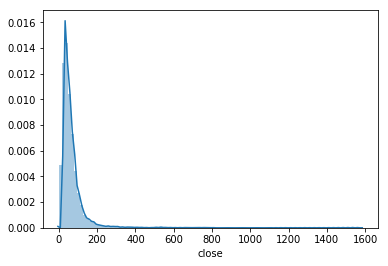

In [25]:
# Lets make some plots
sns.distplot(stocks['close'], bins=100, kde=True)


Exercise: 

What do you see here? What does the above chart tell us about the distribution of prices?

Instructors: The distribution of prices is always positive. It has a very long tail and a high peak near zero. This is Because we are looking at prices from many different stocks. Stocks tend to have prices that are below $100, for convenience of trading small amounts.  But there are a few very high priced stocks. 

For convenience let's take a sample of a few stocks that we can investigate.  

In [34]:
sample_tickers = ['CF', 'SCHW', 'CHK', 'CVX', 'CMG', 'CB'] # this is just a short subsample of tickers to make it easier to look at behaviors.
sample_tickers

['CF', 'SCHW', 'CHK', 'CVX', 'CMG', 'CB']

We typically use close price data when working with daily market data because the open price is sometimes affected by the dynamics of traders reacting to new information that has accumulated overnight. 

Let's reshape our data as well so that each date is our index and each colum is the data for one ticker.  This aproach is called Tidy Data.  For more information on rearranging your data see (https://en.wikipedia.org/wiki/Tidy_data), or you can learn from the excellent work by [Hadley Wickham](https://vita.had.co.nz/papers/tidy-data.pdf). 

In [30]:
closes = stocks.pivot(index='dt', columns='symbol', values='close') # reorganise the data
# Do you undeerstand the new shape of the data?
closes.head(6)

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XLNX,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZTS
dt,,,,,,,,,,,,,,,,,,,,,
2010-01-04,22.389128,4.77,40.380001,30.572857,NaN,26.629999,26.129884,42.070000,37.090000,31.670000,...,25.379999,69.150002,35.330002,8.63,NaN,17.100000,25.226457,60.020000,13.33,NaN
2010-01-05,22.145923,5.31,40.139999,30.625713,NaN,26.440001,25.918773,42.330002,37.700001,31.620001,...,25.059999,69.419998,34.910000,8.64,NaN,17.230000,25.140187,61.919998,13.80,NaN
2010-01-06,22.067240,5.09,40.490002,30.138571,NaN,26.190001,26.062713,42.779999,37.619999,31.559999,...,24.889999,70.019997,35.139999,8.56,NaN,17.170000,24.960462,61.900002,15.00,NaN
2010-01-07,22.038626,5.24,40.480000,30.082857,NaN,25.770000,26.278623,42.740002,36.889999,31.309999,...,24.639999,69.800003,35.599998,8.60,NaN,16.700001,24.953272,63.320000,16.68,NaN
2010-01-08,22.031474,5.14,40.639999,30.282858,NaN,26.049999,26.412967,42.570000,36.689999,31.490000,...,25.000000,69.519997,35.599998,8.57,NaN,16.700001,24.960462,61.990002,16.41,NaN
2010-01-11,22.045780,5.04,40.240002,30.015715,NaN,26.340000,26.547311,42.529999,36.209999,31.309999,...,24.740000,70.300003,36.060001,8.78,NaN,16.740000,25.391804,63.360001,16.51,NaN


### Now that we have our data neatly arranged we can really dive into visualizing it.  

Let's generate plots that can show us what theprice of a single share of stock is worth.

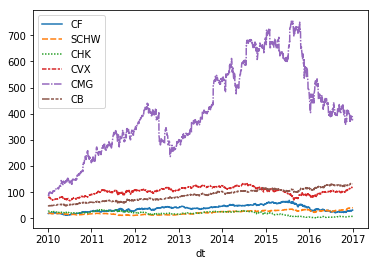

In [37]:
# This is a Seaborn line plot using our subset of tickers
sns.lineplot(data=closes[sample_tickers]) 

Looking at the small gaps in the data makes me wonder if the data is continuous.

In [38]:
closes.index[:50] # Note the gaps in dates

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15', '2010-01-19', '2010-01-20',
               '2010-01-21', '2010-01-22', '2010-01-25', '2010-01-26',
               '2010-01-27', '2010-01-28', '2010-01-29', '2010-02-01',
               '2010-02-02', '2010-02-03', '2010-02-04', '2010-02-05',
               '2010-02-08', '2010-02-09', '2010-02-10', '2010-02-11',
               '2010-02-12', '2010-02-16', '2010-02-17', '2010-02-18',
               '2010-02-19', '2010-02-22', '2010-02-23', '2010-02-24',
               '2010-02-25', '2010-02-26', '2010-03-01', '2010-03-02',
               '2010-03-03', '2010-03-04', '2010-03-05', '2010-03-08',
               '2010-03-09', '2010-03-10', '2010-03-11', '2010-03-12',
               '2010-03-15', '2010-03-16'],
              dtype='datetime64[ns]', name='dt', freq=None)

It seems to be missing weekends and holidays, such as the missing '2010-01-09' and '2010-01-10'.  
Lets forward fill these missing data as an exercise.  
With financial time series data, we forward fill, because if we were to use information from the future, any statistics, analytics or predictors based on that information could have an unrealistic edge.  It is a common mistake in research to think that you have a valuable forecast only to find that you are somehow leaking information from the future.  Then when you implement that forecast in real time testing, it no longer is as predictive. 

Exercise: Forward fill the missing dates.  Hint: use a pandas method.

In [41]:
#Instructor Notes: sample answer
closes.ffill()

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XLNX,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZTS
dt,,,,,,,,,,,,,,,,,,,,,
2010-01-04,22.389128,4.77,40.380001,30.572857,NaN,26.629999,26.129884,42.070000,37.090000,31.670000,...,25.379999,69.150002,35.330002,8.63,NaN,17.100000,25.226457,60.020000,13.330000,NaN
2010-01-05,22.145923,5.31,40.139999,30.625713,NaN,26.440001,25.918773,42.330002,37.700001,31.620001,...,25.059999,69.419998,34.910000,8.64,NaN,17.230000,25.140187,61.919998,13.800000,NaN
2010-01-06,22.067240,5.09,40.490002,30.138571,NaN,26.190001,26.062713,42.779999,37.619999,31.559999,...,24.889999,70.019997,35.139999,8.56,NaN,17.170000,24.960462,61.900002,15.000000,NaN
2010-01-07,22.038626,5.24,40.480000,30.082857,NaN,25.770000,26.278623,42.740002,36.889999,31.309999,...,24.639999,69.800003,35.599998,8.60,NaN,16.700001,24.953272,63.320000,16.680000,NaN
2010-01-08,22.031474,5.14,40.639999,30.282858,NaN,26.049999,26.412967,42.570000,36.689999,31.490000,...,25.000000,69.519997,35.599998,8.57,NaN,16.700001,24.960462,61.990002,16.410000,NaN
2010-01-11,22.045780,5.04,40.240002,30.015715,NaN,26.340000,26.547311,42.529999,36.209999,31.309999,...,24.740000,70.300003,36.060001,8.78,NaN,16.740000,25.391804,63.360001,16.510000,NaN
2010-01-12,21.781117,5.08,39.540001,29.674286,NaN,26.520000,26.470542,42.259998,35.660000,30.010000,...,24.049999,69.949997,35.799999,8.85,NaN,16.680000,25.873473,62.139999,16.049999,NaN
2010-01-13,21.952789,5.48,40.090000,30.092857,NaN,27.040001,26.528119,42.740002,36.279999,30.000000,...,24.260000,69.669998,36.299999,8.95,NaN,16.900000,25.801583,62.549999,16.350000,NaN
2010-01-14,22.281832,5.59,39.560001,29.918571,NaN,27.209999,26.556907,43.119999,35.900002,29.969999,...,24.110001,69.680000,36.570000,8.89,NaN,17.120001,26.081955,62.730000,16.709999,NaN


## 3. Developing analytics -Correlation

[Correlation](https://en.wikipedia.org/wiki/Correlation_and_dependence) is the statistical tendency of two variables to move together.  It measures of the strength of the linear relationship between two numeric variables.  It can range between 1, which indicates that if 1 variable increases then the other will as well, to -1 which means that if 1 variable increases then the other decreases.  At 0 then the change on 1 variable gives you no (linear) information about the likely change in the other.  Correlation does not indicate which variable causes a change in the other, leading to the wisdom that *correlation is not causation*.

Pandas has a convenient method that computes a matrix or correlations between each of the columns.  

In [57]:
correlation_matrix = closes.corr() # compute the correlations between every pair of stocks
correlation_matrix.iloc[0:6,0:6] # display the correlation matrix for the first 6 stocks

symbol,A,AAL,AAP,AAPL,ABBV,ABC
symbol,,,,,,
A,1.000000,0.842542,0.853869,0.778503,0.758350,0.831275
AAL,0.842542,1.000000,0.937780,0.858325,0.802755,0.940386
AAP,0.853869,0.937780,1.000000,0.898114,0.872555,0.939475
AAPL,0.778503,0.858325,0.898114,1.000000,0.871397,0.886144
ABBV,0.758350,0.802755,0.872555,0.871397,1.000000,0.840566
ABC,0.831275,0.940386,0.939475,0.886144,0.840566,1.000000


### Which are the most corelated stocks?  Do you only want positive corelations? 
Lets only select the strongest correlations that are less than 1.0.

Thought Question: 
Why don't we want series with corelation of 1?

Select the top 100 for this exercise.  

Instructor Notes: In investing negative correlations are just as useful as positive correlations of the same magnitude because they contain the same strength of information.

*Notes from Sarah*  
Can you add comments to the code?

In [43]:
# take the magnitude of correlations, shift from a 2d matrix to a vector and sort them descending.
ordered_correlations = correlation_matrix.abs().unstack().sort_values(kind="quicksort")

In [44]:
# Now get rid of those with NaNs for simplicity
ordered_correlations = ordered_correlations.dropna()

In [45]:
# Now take the top 100
top = ordered_correlations[ordered_correlations<0.99]

In [46]:
top[-100:]

symbol  symbol
MHK     V         0.986251
V       MHK       0.986251
HON     CMCSA     0.986296
CMCSA   HON       0.986296
WM      RSG       0.986308
RSG     WM        0.986308
HON     DHR       0.986325
DHR     HON       0.986325
NEE     LNT       0.986380
LNT     NEE       0.986380
EFX     NWL       0.986412
NWL     EFX       0.986412
ADBE    NOC       0.986426
NOC     ADBE      0.986426
AGN     HBI       0.986502
HBI     AGN       0.986502
LOW     HD        0.986548
HD      LOW       0.986548
FISV    LMT       0.986843
LMT     FISV      0.986843
NI      CMS       0.986861
CMS     NI        0.986861
FISV    BCR       0.986881
BCR     FISV      0.986881
CMCSA   TMK       0.986950
TMK     CMCSA     0.986950
STZ     AYI       0.987010
AYI     STZ       0.987010
LNT     DTE       0.987062
DTE     LNT       0.987062
                    ...   
LMT     STZ       0.988230
STZ     LMT       0.988230
UNH     CTAS      0.988245
CTAS    UNH       0.988245
HON     MMC       0.988314
MMC     HON  

### Now let's implement this, with 1 pair.
We need to calculate a ratio of 1 stock's price to another, so that we can know how much of each to buy and sell.  We will look at the relationship between LMT (Lockheed Martin) and ADBE (Adobe), chosen somewhat at random from the pairs with high correlations.

In [62]:
top['LMT']['ADBE'] # What is the correlation?

0.9864260247893898

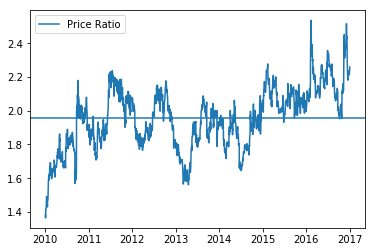

In [63]:
stock1 = closes['LMT'] # get the first price series
stock2 = closes['ADBE'] # get the second price series
ratios = stock1 / stock2 # calculate the ratio of prices
sns.lineplot(data=ratios) # Plot the price ratio
plt.axhline(ratios.mean()) # Draw the average value
# Add a legend and title for clarity
plt.legend(['Price Ratio']) 
plt.title('Comparing LMT to ADBE')

Our pair of stocks do seem to float around some ratio and return to it.  At a point where the ratio is far away from its mean, we will by some of stock1 and sell short some of stock2 so that we are net neutral in our exposure to the stocks.

To know when is an interesting time, we will want to use the Z-score, which is the ratio value minus it's mean divided by the standard deviation of the ratio.  This will tell us how unusual this move is.  


Instructor Notes: Only in case a student asks us... When we take the z-score below with the whole time series we are using information from the future about what the mean and standard deviation of the ratios will be. We will discuss this when we are talking about risks.

Text(0.5, 1.0, 'Z scores for the Ratio')

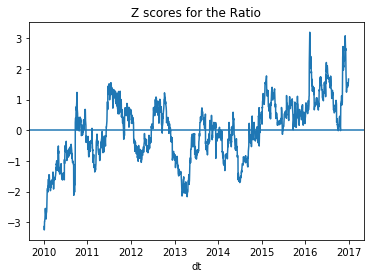

In [66]:
zscores = zscore(ratios) # Let's transform to a series of Z-scores
sns.lineplot(x=ratios.index, y=zscores) # Make another line plot
plt.axhline(zscores.mean()) # Thought question: Why does the blue line sit at 0?
plt.title('Z scores for the Ratio') 

So here we can imagine entering the trade in early 2010 as the z score sits at -3 and then taking our gains as the line comes back towards 0.  We could also do the same in 2016 as the z score briefly was at +3.  We can take advantage of both positive and negative deviations.  

### The problem with correlation
Correlation is not often used in real pairs trading.  Just because two price series are correlated, we do not know that they will be profitable.  We would like to know that if there is a price difference between two stocks that grows, that it will shrink in the future.  Two stocks can be correlated if there is a price ratio that keeps on growing without a return towards a fixed value.  

So next let's briefly look at another statistical property called cointegration.  

## 3. Developing analytics - Cointegration 
This piece is optional if you are not into statistics

Cointegration is the idea that two or more series will have a linear combination that is stationary.  In our two stock example, it means that the ratio we computed will revert back to some mean value as opposed to drifting higher or lower over time.  While corelation is the statistical tendency of two variables to move together, cointegration is a slightly stricter requirement.  

In [67]:
coint_t, pval, crit_val = coint(stock1, stock2) # It is nearly as easy to use cointegration
print(f'The statistic is {coint_t}, the p-value is {pval} and the critical values to be significant at the 1%/5%/10% levels are {crit_val}')

The statistic is -4.172646976066515, the p-value is 0.004011620921274331 and the critical values to be significant at the 1%/5%/10% levels are [-3.90266995 -3.33960188 -3.04685928]


So we can see that our stock pair also passes the cointegration test, though that will not always be the case.  Here you can find more information on [cointegration](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html). 

#### Optional Exercise:
How would you test each of our stocks for cointegration?  Hint: Pandas has a method that we used for correlation. 

Repeat the prior steps from the corelation section and determine which would be the most promissing pairs?

Instructor notes: students can get inspiration from the source code for [corr](https://github.com/pandas-dev/pandas/blob/v1.0.3/pandas/core/frame.py#L7414-L7500)

In [82]:
# Sample Answer
def coi(ser0, ser1):
    coint_t, _, _ = coint(y0=ser0, y1 = ser1) # coint returns 3 values but we only want the first one
    return coint_t

# This is relatively slow slow let's only do it for a few stocks by using iloc
coint_matrix = closes.iloc[:, 0:10].corr(method=coi) # compute the correlations between every pair of stocks
coint_matrix

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI
symbol,,,,,,,,,,
A,1.000000,-3.025735,-3.164768,-2.236678,-2.699198,-2.247050,-2.263404,-2.488273,-2.979047,-3.106137
AAL,-3.025735,1.000000,-3.219111,-2.346595,-2.651875,-2.306165,-2.287765,-1.656452,-2.355832,-2.088296
AAP,-3.164768,-3.219111,1.000000,-2.586864,-3.401075,-3.019427,-2.196426,-2.763874,-3.145235,-2.604105
AAPL,-2.236678,-2.346595,-2.586864,1.000000,-3.898998,-2.022631,-2.361862,-2.132172,-2.227024,-2.411079
ABBV,-2.699198,-2.651875,-3.401075,-3.898998,1.000000,-2.898398,-2.563978,-2.390258,-2.388665,-2.380738
ABC,-2.247050,-2.306165,-3.019427,-2.022631,-2.898398,1.000000,-2.682629,-1.317358,-1.388758,-1.425700
ABT,-2.263404,-2.287765,-2.196426,-2.361862,-2.563978,-2.682629,1.000000,-1.474081,-1.470143,-1.777405
ACN,-2.488273,-1.656452,-2.763874,-2.132172,-2.390258,-1.317358,-1.474081,1.000000,-2.766907,-3.411711
ADBE,-2.979047,-2.355832,-3.145235,-2.227024,-2.388665,-1.388758,-1.470143,-2.766907,1.000000,-2.887020


## 4. Risk review: improving accuracy and realism
- Time keeps on [slipping into the future](https://youtu.be/6a6lAwbE1J4)
- Transaction costs 
- Multiple hypothesis bias

We have ignored many of the important things that trip up real finance strategies.  Let's discuss just a few. 

For one thing we have been simplistic about time.  Did you notice?  Where have we made coding assumptions that have lookahead bias.  That is, where have our strategies relied on statistics with information from the future?  To fix this we should be careful about backtesting, which is a process of realistically using historical data, but not using information that would not be available to a decision maker at that point in the past.  

We have also assumed it is free to trade securities.  In reality backtests will often look profitable until you take transaction costs into account, at which point the sad trombone of losses starts playing.  If transaction costs make a strategy unprofiatble, that false opportunity can persist in the market for a long time.  

Finally we have looked at corelations and cointegrations on how many pairs?  Given all those possibilities surely one will look promising, if just by random chance.  Their are statistics that we can adjust to take this into account.  



Instructor Notes:
"Did you notice?" This is where we refer to the z-score looking ahead.

## 6. Your turn to move forward. 

Consider going forward with data sciences on Azure. Here are two paths forward:

Get started with Machine Learning with an Azure Data Science Virtual Machine https://docs.microsoft.com/en-us/learn/paths/get-started-with-azure-dsvm/

Explore AI solution development with data science services in Azure
https://docs.microsoft.com/en-us/learn/paths/explore-data-science-tools-in-azure/

## 5. Taking the next steps

We have looked at a system that looks at one stock.  Next you could move forward with implementations.  You could generate zscores using only backward looking data, to remove lookahead bias.  You might want a function that moves through days and chooses only strong zscores at that time.  There are several packages such as [Backtrader](www.backtrader.com) or [Zipline](https://www.zipline.io/) among others that can help with these tasks.

On pairs trading: 

For a [non-technical overview](https://www.linkedin.com/learning/the-data-science-of-economics-banking-and-finance-with-barton-poulson) 

Academic review of [Pairs trading with Stock Data](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3162800) 

More about [Pairs](http://stat.wharton.upenn.edu/~steele/Courses/434/434Context/PairsTrading/PairsTradingQFin05.pdf) 

And yet [another](https://www.stat.berkeley.edu/~aldous/Research/Ugrad/Amy_Zhang.pdf) 

Correlation, Dependence and Cointegration:
https://en.wikipedia.org/wiki/Correlation_and_dependence 

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html 

https://press.princeton.edu/books/hardcover/9780691043012/the-econometrics-of-financial-markets 

Tidy Data 
https://vita.had.co.nz/papers/tidy-data.pdf 

Practical Review of the Implications of Multiple Hypothesis Testing
[Why Most Published Research Findings Are False](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1182327/)